## Accessing and visualizing Sentinel 1 RTC data

### Requirements


#### 1. Conda environment 

At the time of writing this notebook, the base jupyter environment in the MAAP ADE has a version of python that is incompatible with this notebook. Therefore, we provide a configuration file for you to create a fresh conda environment. Copy the content below to a yaml file, create the environment and activate it.

#### 2. [Temporary because of a [bug in the STAC database](https://github.com/NASA-IMPACT/veda-data-pipelines/issues/313#issuecomment-1473285153)]

Within the above environment 

- Git clone the [`stackstac` source code repo](https://github.com/gjoseph92/stackstac)
- From the root folder, install the repo as an editable package with `pip` : `pip install -e .`
- Add this line of code above [this line](https://github.com/gjoseph92/stackstac/blob/d53f3dc94e49b95b950201f9e53539a92b1458b6/stackstac/prepare.py#L192):


  ```asset_epsg = int(asset_epsg)```


In [1]:
from stackstac import stack, mosaic
import pystac_client
import matplotlib.pyplot as plt 
import numpy as np

We first create a client to access the STAC test catalog.

In [2]:
URL = "https://stac.test.maap-project.org"
catalog = pystac_client.Client.open(URL)

We select a bounding box of interest to filter items, here around Oslo, and proceed to the catalog query.

In [3]:
bbox = [10.14,59.64,11.37,60.26]

In [4]:
stac_collection = catalog.search(
    collections=["s1-rtc-seasonal-composite"],
    bbox=bbox,
)

We keep only the `vh` polarization, for the purpose of visualization. We end up with two items.

In [5]:
stac_items = [i for i in stac_collection.get_all_items() if 'vh' in i.id]

In [6]:
len(stac_items)

2

We hand this over to `stackstac` to create an `xarray.DataArray` object, reproject to 32633, and "mosaic" the two items.

In [7]:
da_dask_array = mosaic(stack(stac_items, epsg=32633))

This creates a dask array, the data is not yet loaded in memory

In [8]:
da_dask_array

<xarray.DataArray 'stackstac-43ed1d1cc7a9098930e09b264eefddd2' (band: 1,
                                                                y: 7409, x: 9666)>
dask.array<mosaic-aggregate, shape=(1, 7409, 9666), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band       (band) <U11 'cog_default'
  * x          (x) float64 2.542e+05 2.543e+05 2.543e+05 ... 5.442e+05 5.442e+05
  * y          (y) float64 6.816e+06 6.816e+06 6.816e+06 ... 6.594e+06 6.594e+06
    proj:epsg  float64 3.263e+04
    epsg       int64 32633
Attributes:
    spec:        RasterSpec(epsg=32633, bounds=(254250.0, 6593700.0, 544230.0...
    crs:         epsg:32633
    transform:   | 30.00, 0.00, 254250.00|\n| 0.00,-30.00, 6815970.00|\n| 0.0...
    resolution:  30.0

We now load the data. We can do that because it is a small amount. Note that this line might fail the first time and throw a `CPLE_AppDefinedError`, triggered upstream by a time out error. Run it a second time or a third time and it will work -- there is probably a parameter we can pass to increase
the tolerance but I could not find quickly how to do it.

In [12]:
da = da_dask_array.load()

We look at the distribution of the data by finding a couple quantiles. It tells us that a third of the data is equal to 0, and then most of it below 0.07, with a couple 'outliers' (see the maximum value), typically referred to as "radar speckle". We will clip these for visualization. 

In [13]:
da.quantile(q=[0.3, 0.5, 0.999, 0.999999, 1]).values

array([0.00000000e+00, 2.94191120e-02, 7.31380039e-02, 7.75944124e+00,
       2.73948303e+02])

In addition, the high resolution will make the plotting quite slow, so we coarsen that data to increase the speed of the mapping step. We coarsen it by taking the average value over 4x4 pixel boxes.

In [14]:
da.shape

(1, 7409, 9666)

In [15]:
coarsened = da.coarsen(x=4, y=4, boundary="trim").mean()

We top-code the data to 0.07, given the distribution of the data (see above). 

In [16]:
coarsened_clipped = np.minimum(coarsened, 0.07)

(array([1677313.,   45500.,  122959.,  231431.,  370860.,  681259.,
         993177.,  329259.,   18390.,    4284.]),
 array([0.   , 0.007, 0.014, 0.021, 0.028, 0.035, 0.042, 0.049, 0.056,
        0.063, 0.07 ]),
 <BarContainer object of 10 artists>)

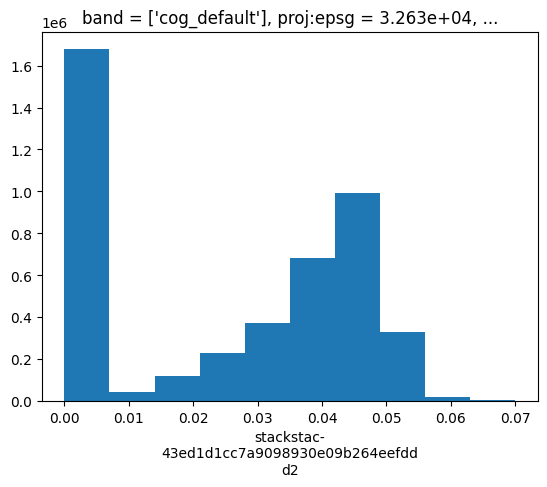

In [17]:
coarsened_clipped.plot.hist()

Finally we plot this as a 2D image with a gray color scale.  

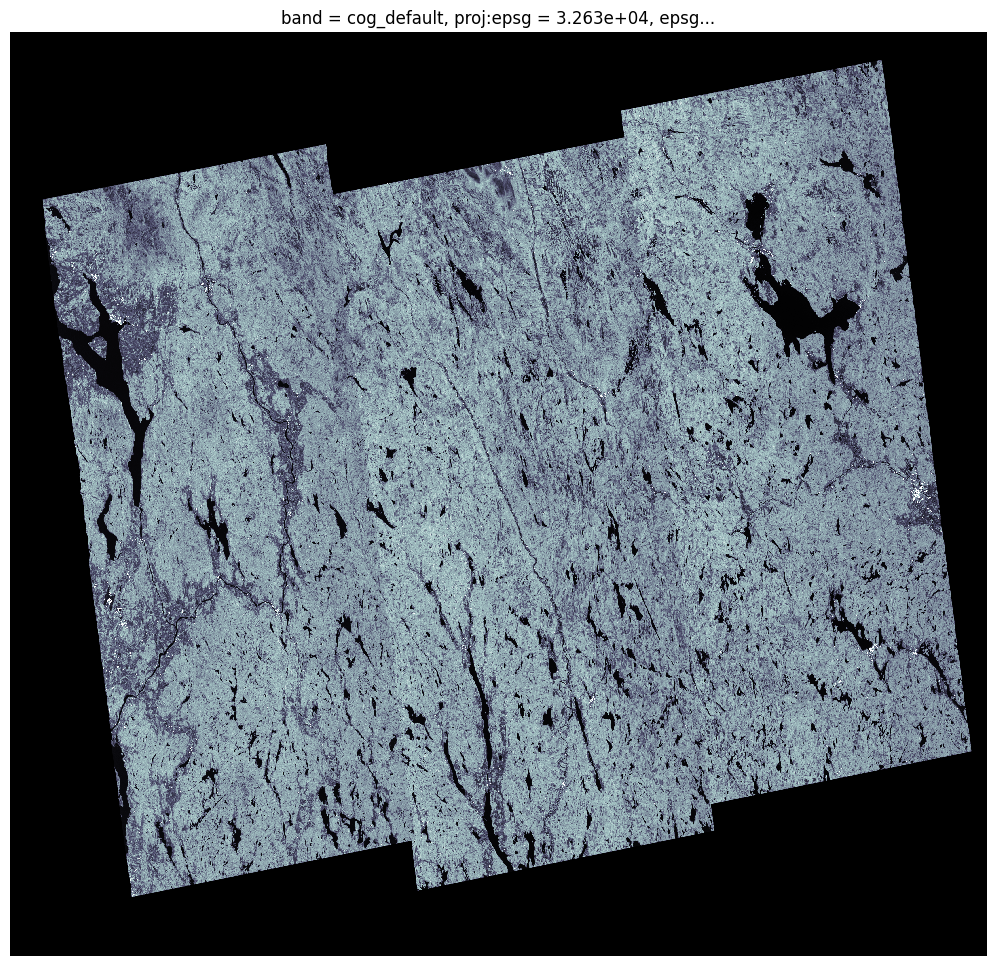

In [18]:
img = (
    coarsened_clipped
    .squeeze('band') # this is a singleton dimension, but plot() complains, so we are removing it.
    .plot.imshow(cmap="bone", size=12, aspect=1.05, add_colorbar=False)
)
img.axes.set_axis_off();